In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

### Set default device to <b>CUDA</b> if available or else to <b>CPU</b>

In [2]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

# Location of Dataset

In [3]:
DATA = "/home/pushpull/mount/intHdd/dataset/assembly/smbly.txt"

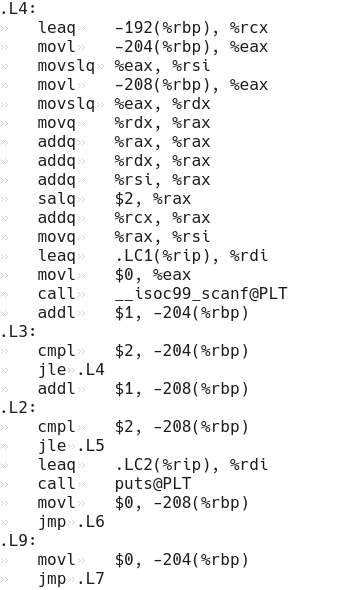

In [4]:
from IPython.display import Image
Image(filename='smbly.png') 

In [5]:
with open(DATA, 'r') as file:
    text = file.read()

# Data Preprocessing

Gather all the unique values in the dataset<br>
<b>chars</b> : Tuple of all the unique elements in the dataset

In [6]:
chars = tuple(set(text))

### Encode all the unique elements

<b>int2char</b> : Convert <i>encoded integer</i> value into original value (Used at end when final is to be observed)<br>
<b>char2int</b> : Encode the data elements

In [7]:
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

#### Count of unique elements in the dataset

In [8]:
len(int2char)

74

In [9]:
int2char

{0: '3',
 1: 'c',
 2: '\t',
 3: 'p',
 4: 'P',
 5: 'G',
 6: 'B',
 7: '%',
 8: '4',
 9: ',',
 10: 'x',
 11: 'b',
 12: 'A',
 13: 'o',
 14: '\n',
 15: 'a',
 16: '2',
 17: '5',
 18: 'E',
 19: 'X',
 20: ' ',
 21: 'H',
 22: 'W',
 23: '"',
 24: 'h',
 25: '0',
 26: 'm',
 27: 'z',
 28: '=',
 29: '7',
 30: 'F',
 31: 'u',
 32: '_',
 33: 'i',
 34: 'f',
 35: 't',
 36: 'k',
 37: 's',
 38: 'T',
 39: 'n',
 40: '\\',
 41: '1',
 42: 'U',
 43: 'D',
 44: 'w',
 45: 'C',
 46: 'R',
 47: '(',
 48: 'Z',
 49: 'y',
 50: 'I',
 51: ')',
 52: 'g',
 53: 'L',
 54: '.',
 55: ':',
 56: '6',
 57: '8',
 58: 'r',
 59: 'q',
 60: 'M',
 61: 'v',
 62: 'K',
 63: '-',
 64: '@',
 65: 'l',
 66: 'd',
 67: 'O',
 68: 'e',
 69: 'N',
 70: 'S',
 71: '$',
 72: 'j',
 73: '9'}

<b>encoded</b> : Encoded form of whole dataset

In [10]:
encoded = torch.tensor([char2int[ch] for ch in text]).to(DEVICE)

# Character Level LSTM

<b>SMBLRnet</b> : A character level LSTM model<br>
><b>no_token</b> : Count of unique values<br>
<b>token</b> : Unique values in dataset<br>
<b>no_layer</b> : Count of layers to stack inside LSTM cell<br>
<b>drop_prob</b> : Probability of dropping (nulling) weight for single pass from a neuron

In [11]:
class SMBLYnet(nn.Module):
    
    def __init__(self, parameter):
        super().__init__()
        
        self.no_token  = parameter.get("no_token")
        self.token     = parameter.get("token")
        self.no_hidden = parameter.get("no_hidden")
        self.no_layer  = parameter.get("no_layer")
        self.drop_prob = parameter.get("drop_prob")
        
        self.int2char  = dict(enumerate(self.token))
        self.char2int  = {ch: ii for ii, ch in self.int2char.items()}
        
        # Initialize LSTM with above parameters
        self.init_network()
       
    
    def init_network(self):
        
        self.lstm    = nn.LSTM(len(self.token), self.no_hidden, self.no_layer, dropout=self.drop_prob, batch_first=True).to(DEVICE)
        self.dropout = nn.Dropout(self.drop_prob).to(DEVICE)
        self.out     = nn.Linear(self.no_hidden, len(self.token)).to(DEVICE)
      
    
    def forward(self, x, h_c):
        
        x_, h_c = self.lstm(x, h_c)
        x_      = self.dropout(x_)
        x_      = x_.contiguous().view(-1, self.no_hidden)
        x_      = self.out(x_)
        return x_, h_c
    

# Generate data for training and validating

<b>one_hot_encode</b> : Returns one hot encoded tensor for given values and number of classes

In [12]:
def one_hot_encode(x, no_token):
    one_hot = torch.tensor(np.zeros([x.shape[0], x.shape[1], no_token])).type(torch.FloatTensor).to(DEVICE)
    one_hot.scatter_(2, x.reshape([x.shape[0], x.shape[1], 1]), 1)
    return one_hot

<b>generate_data</b> : Creates sequenced and batched data for input in LSTM
><b>data</b> : Input data<br>
><b>batch_size</b> : Size of batch into which, data is to be reshaped<br>
><b>no_token</b> : Count of unique characters in the dataset<br>
>Input data is one hot encoded while true output is not

In [13]:
def generate_data(data, batch_size, seq_len, no_token):
    id_ = 0
    for i in range(data.shape[0]):
        
        encode    = one_hot_encode(data[i], no_token)

        one_hot_x = encode[:, :-1]
        y         = data[i, :, 1:].reshape(-1)
        
        yield one_hot_x, y

# Training Model

><b>model</b> : Define model to be trained<br>
><b>data</b> : Dataset to be used for training<br>
><b>no_epochs</b> : Number of epochs for which, model is to be trained<br>
><b>batch_size</b> : Size of batch to enter parallely into model<br>
><b>seq_len</b> : Length of sequence for which, dependancy is to be mapped<br>
><b>lr</b> : Learning rate of model<br>
><b>clip</b> : Clip gradients above defined threshold<br>
><b>no_token</b> : Count of unique elements in the dataset<br>

In [14]:
def train(parameter):
    model      = parameter.get("model")
    data       = parameter.get("data")
    no_epochs  = parameter.get("no_epochs")
    batch_size = parameter.get("batch_size")
    seq_len    = parameter.get("seq_len")
    lr         = parameter.get("alpha")
    clip       = parameter.get("clip")
    no_token   = parameter.get("no_token")
    loss       = parameter.get("loss")
    
    # Size of dataset that can be reshaped into seq_len and batch_size
    net_size   = ((len(data) // (seq_len*batch_size))*(seq_len*batch_size))
    data      = data[:net_size].reshape(-1, batch_size, seq_len)
    
    optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
    
    step        = 0
    train_error = []
    eval_error  = []
    
    for epoch_no in range(no_epochs):
        
        # initialize hidden state and cell state of LSTM
        weight = next(model.parameters()).data
        h_c   = (weight.new(model.no_layer, batch_size, model.no_hidden).zero_().to(DEVICE),
                  weight.new(model.no_layer, batch_size, model.no_hidden).zero_().to(DEVICE))
        
        for x, y in generate_data(data, batch_size, seq_len, no_token):
            
            model.train()
            
            h_c = tuple([unit.data for unit in h_c])
            
            model.zero_grad()
            
            # generate next value generated by model
            out, h_c = model(x, h_c)
            # calculate error of model
            error     = loss(out, y)
            train_error.append(error)
            # backprop error
            error.backward()

            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            
            step += 1
            
            if step%500==0:
                print("Epoch: {}/{}...".format(epoch_no+1, no_epochs),
                      "Step: {}...".format(step),
                      "Loss: {:.4f}...".format(error.item()))


In [15]:
no_token  = len(int2char)
token     = chars
no_hidden = 512
no_layer  = 2
drop_prob = 0.5

model_parameter = {
                    "no_token":no_token,
                     "token":token,
                     "no_hidden":no_hidden,
                     "no_layer":no_layer,
                     "drop_prob":drop_prob
                    }

In [16]:
smblr = SMBLYnet(model_parameter)

In [17]:
model      = smblr
data       = encoded
no_epochs  = 10
batch_size = 1
seq_len    = 13
alpha      = 0.0001
clip       = 5
no_token   = len(int2char)
loss       = nn.CrossEntropyLoss()

train_parameter = {
                    "model":model,
                    "data":data,
                    "no_epochs":no_epochs,
                    "batch_size":batch_size,
                    "seq_len":seq_len,
                    "alpha":alpha,
                    "clip":clip,
                    "no_token":no_token,
                    "loss":loss
                  }

In [18]:
train(train_parameter)

Epoch: 1/10... Step: 500... Loss: 3.3665...
Epoch: 1/10... Step: 1000... Loss: 4.0250...
Epoch: 1/10... Step: 1500... Loss: 3.4853...
Epoch: 1/10... Step: 2000... Loss: 2.8394...
Epoch: 2/10... Step: 2500... Loss: 1.9439...
Epoch: 2/10... Step: 3000... Loss: 3.5306...
Epoch: 2/10... Step: 3500... Loss: 3.5861...
Epoch: 2/10... Step: 4000... Loss: 1.4822...
Epoch: 3/10... Step: 4500... Loss: 2.5482...
Epoch: 3/10... Step: 5000... Loss: 1.1143...
Epoch: 3/10... Step: 5500... Loss: 1.0984...
Epoch: 3/10... Step: 6000... Loss: 3.5298...
Epoch: 3/10... Step: 6500... Loss: 0.8079...
Epoch: 4/10... Step: 7000... Loss: 0.8036...
Epoch: 4/10... Step: 7500... Loss: 0.7472...
Epoch: 4/10... Step: 8000... Loss: 1.0396...
Epoch: 4/10... Step: 8500... Loss: 1.7000...
Epoch: 5/10... Step: 9000... Loss: 1.0696...
Epoch: 5/10... Step: 9500... Loss: 1.7105...
Epoch: 5/10... Step: 10000... Loss: 2.3278...
Epoch: 5/10... Step: 10500... Loss: 1.4511...
Epoch: 5/10... Step: 11000... Loss: 0.6574...
Epoch: 6

# Save trained model

In [19]:
model_name = "smblr.rits"

In [20]:
torch.save(model, model_name)

/usr/lib/python3.8/site-packages/torch/serialization.py:291: UserWarning: Couldn't retrieve source code for container of type SMBLYnet. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/usr/lib/python3.8/site-packages/torch/serialization.py:291: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/usr/lib/python3.8/site-packages/torch/serialization.py:291: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/usr/lib/python3.8/site-packages/torch/serialization.py:291: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "

# Load saved model

In [21]:
model = torch.load(model_name)

with open(model_name, 'wb') as f:
    torch.save(model, f)

# Making inference with model

In [22]:
def predict(model, samp, h_c):
    x_ = torch.tensor([[model.char2int[samp]]]).to(DEVICE)
    x_ = one_hot_encode(x_, len(model.token))
    
    h_c      = tuple([unit.data for unit in h_c])
    out, h_c = model(x_, h_c)
    
    # predicted outputs are converted into probabilities using softmax function
    pred     = F.softmax(out, dim=1).data[0]
    # from the created distribution of probabilities, single element is sampled according to their probability
    id_x     = np.random.choice(np.arange(len(char2int)), p=pred.cpu().numpy())
    
    return int2char[id_x], h_c

In [23]:
def sample(parameter):
    model   = parameter.get("model")
    key     = parameter.get("key")
    gen_len = parameter.get("gen_len")
    
    model.eval()
    
    gen    = [ch for ch in key]
    
    weight = next(model.parameters()).data
    h_c   = (weight.new(model.no_layer, 1, model.no_hidden).zero_().to(DEVICE),
              weight.new(model.no_layer, 1, model.no_hidden).zero_().to(DEVICE))
    
    for samp in key:
        samp, h_c = predict(model, samp, h_c)
    gen.append(samp)
    
    for i in range(gen_len):
        samp, h_c = predict(model, samp, h_c)
        gen.append(samp)
        
    return ''.join(gen)

In [32]:
key     = "call"
gen_len = 1000

sample_parameter = {"model":model,
                    "key":key,
                    "gen_len":gen_len}

In [33]:
print(sample(sample_parameter))

call	adotr_, %rax
	movq	$B6, %rax
	movq	%rax, %rdi
	cail	_Zotu_itin.LT
.L:
	movl	%rdx, %rdi
	movq	%rax, %rci
	call	_ZNSC5%rii)@caES_0fstrNtaattciteinx_sybe1ESn
o.leG128.LSB0".L1B6
	.csi_starrpaoc
	pushq	%rbp
	movl	%rax, %rax
	cihbdgt146(%r1p)
	.cfi__esfcc7 7, 8
	eot
	.cSi_dffcat 1, @het
	moveb024(%rbp)
.L1:
	movl	leZ228(%rbp)
	ampl	$13, -814(%rbp)
	movl	$4, -16(%rbp)
	jge	.L84
	citlel22 PL 
.L1H8

	.sil	seua1_Ifl.LS11_prit112Gb	_ssbeearI
.LFHA%80
	.si_esist 13
.LS3
	.stf1180aii	.tmpe	%sits
	..EC2mssq	%rbp
	.cfi_def_cfa_efditer 6
	.cfi_LZ9@pescyEREC6, %o.ccofntrrttoc
	pushq	%rbp
	.sfi_eefif 77, 1
	.cfi_nfset -4, -2
	.cfi_offset 14, -16
	movq	%rax, %rbi
	popq	%rbp
	puihq	%rbp
	pe.hf_Zfale	rebt
	.ceiinsnrraprct
.LNB88.L8t2
	.atl_sfsnracc_ctstapttmorifii
eoulut6
	.nybbti2 @oZB3u_stry@.L2AE4:
	.sulbZ1B
	..Stt5tggso"1@t @.LC2H6
	.LEpsfsf	Rt1
.Li:
	movzis84(%rbp), %ax
	movl	%rax, %rl
	addq	%rox, %rax
	addl	$1, -34(%rbp)
	movl%$2, -228(%rbp)
	jle	.L41
.faaddq	%eax, %rdx
	addl	$1, -24(%rbp)
	jm